In [34]:
# pytorch pooling testing
import torch
import torch.nn.functional as F

# create test tensor with shape [1, 3, 16, 16]
x = torch.randn(1, 3, 4, 4)
print(x.shape)
print(x)

torch.Size([1, 3, 4, 4])
tensor([[[[-1.7024e+00,  5.5689e-01,  1.0731e+00, -1.7573e+00],
          [-4.7037e-01, -1.1190e+00, -1.0730e+00, -3.6939e-01],
          [ 1.9904e+00, -2.5125e+00, -3.2967e-01, -2.2169e+00],
          [-1.3117e+00, -3.3055e-01, -1.7157e+00,  1.8355e+00]],

         [[ 1.2296e+00, -7.3973e-01, -2.3545e-03, -8.6042e-01],
          [ 5.5323e-01, -4.2471e-01, -2.2871e-01, -5.1846e-01],
          [ 9.5938e-01,  1.2160e+00, -5.8091e-01,  2.0828e+00],
          [ 3.6003e-01, -2.0097e-01, -7.1026e-01, -2.1482e+00]],

         [[ 8.3097e-01, -8.1817e-01, -8.5773e-02, -6.0082e-02],
          [-6.3229e-01,  2.3359e+00,  1.3277e-01, -8.6374e-01],
          [-3.5268e-01,  1.1585e+00,  3.0578e-01,  2.1951e-01],
          [-1.0654e+00, -3.8137e-01,  1.1621e-01,  1.2763e+00]]]])


In [35]:
# Max pooling along channel dimension
# input: [1, 3, 4, 4]
# output: [1, 1, 4, 4]
y = torch.mean(x, dim=1, keepdim=True)
print(y.shape)
print(y)

torch.Size([1, 1, 4, 4])
tensor([[[[ 0.1194, -0.3337,  0.3283, -0.8926],
          [-0.1831,  0.2641, -0.3896, -0.5839],
          [ 0.8657, -0.0460, -0.2016,  0.0285],
          [-0.6723, -0.3043, -0.7699,  0.3212]]]])


In [37]:
z = torch.max(x, dim=1, keepdim=True)
print(z.values.shape)
print(z.values)

torch.Size([1, 1, 4, 4])
tensor([[[[ 1.2296,  0.5569,  1.0731, -0.0601],
          [ 0.5532,  2.3359,  0.1328, -0.3694],
          [ 1.9904,  1.2160,  0.3058,  2.0828],
          [ 0.3600, -0.2010,  0.1162,  1.8355]]]])


In [38]:
L_c = F.mse_loss(y, z.values)
print(L_c)

tensor(1.2448)


YOLO11n summary: 319 layers, 2,592,180 parameters, 0 gradients, 6.5 GFLOPs
Image tensor shape torch.Size([1, 3, 384, 640])
Blocks Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
)
features output shape torch.Size([1, 16, 192, 320])
features[0] shape torch.Size([16, 192, 320])
img_resized (192, 320, 3)
avg_pool_img_resized_downsampled (192, 320)
max_pool_img_resized_downsampled (192, 320)
feature_map shape (16, 192, 320)
avg_pool_channel_feature shape (192, 320)
max_pool_channel_feature shape (192, 320)
[[     1.8791      1.8823      1.8883 ...      1.9627      1.9627      1.9627]
 [     1.8788      1.8643      1.8165 ...      1.9684      1.9684      1.9684]
 [     1.8128      1.7968      1.8158 ...      1.9684      1.9684      1.9684]
 ...
 [     1.9649      1.9697      1.9771 ...      1.9697      

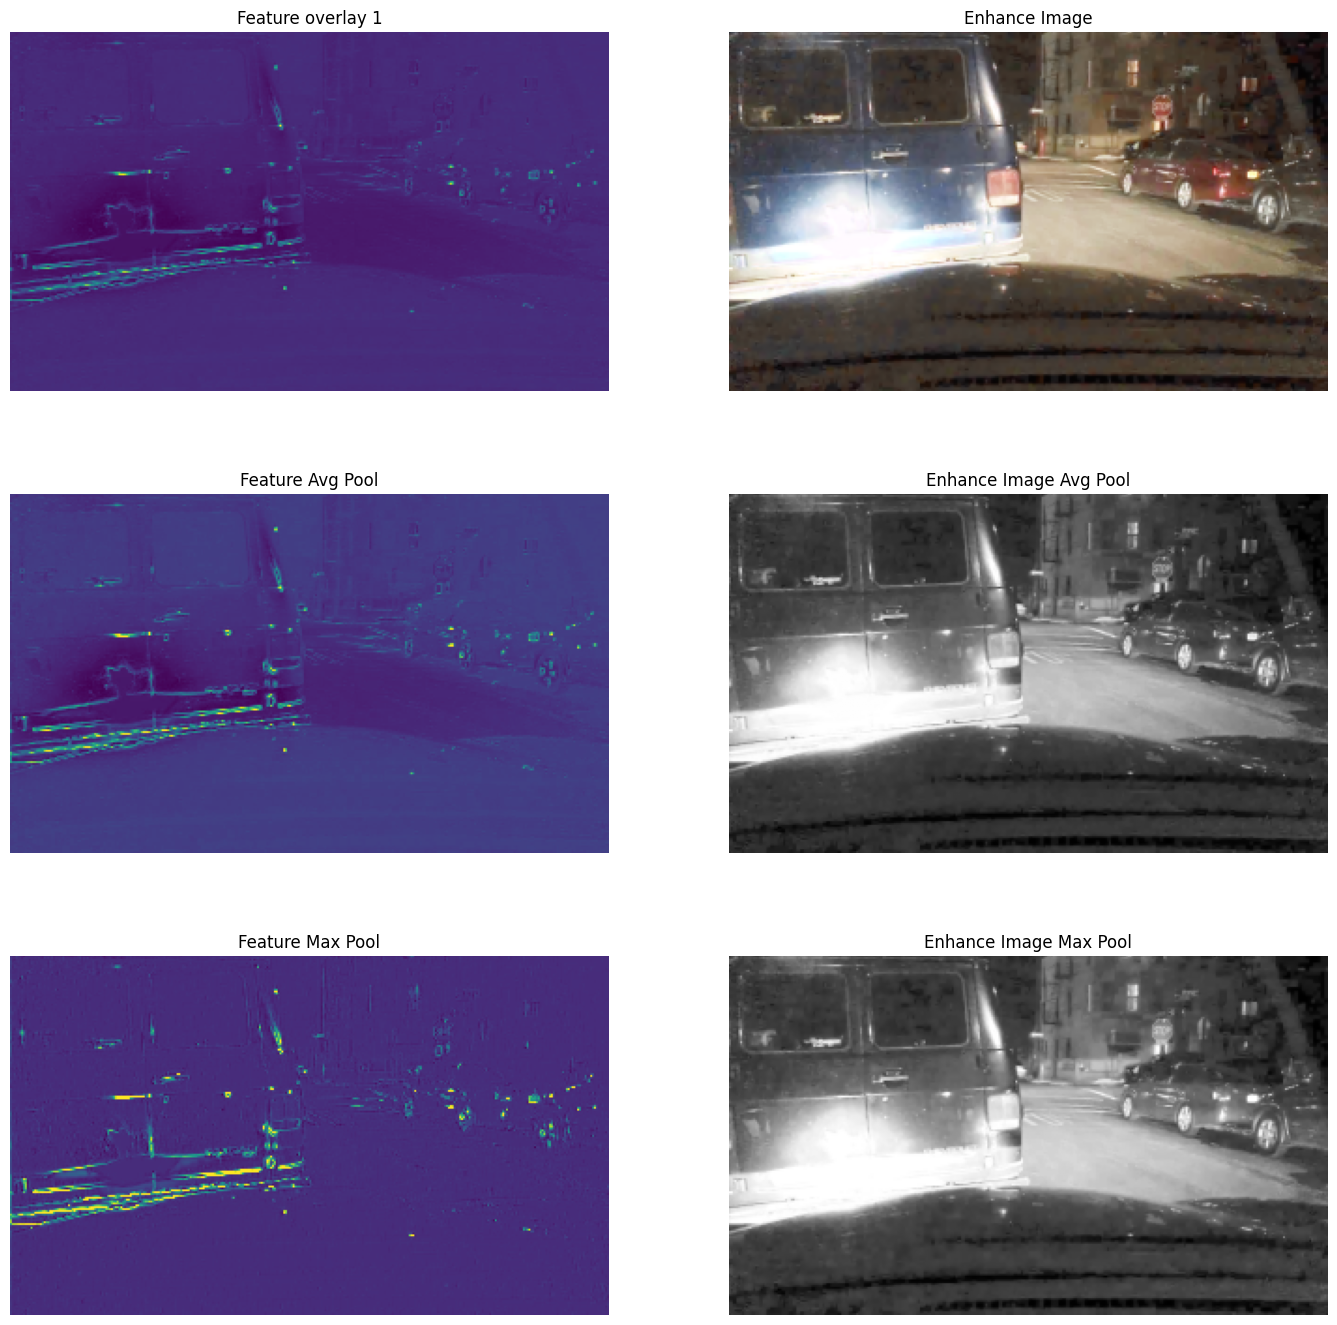

In [16]:
import torch.nn.functional as F
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# Load a model
model = YOLO("../weights/yolo11n-finetuned-bdd100k-night.pt")
model.info()
# Train the model
# results = model.train(data="../ultralytics/cfg/datasets/bdd1k.yaml", epochs=1, device="cpu")
# resize and normalize image for inference
input_width = 640
input_height = 384

index = 28

bddk_images = glob.glob("../../yolo-testing/datasets/bdd128_DLN/images/train/*.jpg")
img = bddk_images[index]
name = img.split("/")[-1]

bddk_enhanced_images = glob.glob("../../yolo-testing/datasets/bdd128_DLN/images_enhanced_VOC_LOL/train/*.png")

img = cv2.imread(img)
img_enhanced = cv2.imread(f"../../yolo-testing/datasets/bdd128_DLN/images_enhanced_VOC_LOL/train/{name[:-4]}_enhanced.png")

img_resized = cv2.resize(img, (input_width, input_height))
img_enhanced_resized = cv2.resize(img_enhanced, (input_width, input_height))

# convert the image to tensor
image_tensor = torch.tensor(img_resized, dtype=torch.float32)

# normalize the image
image_tensor = image_tensor / 255.0

# add batch dimension
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.permute(0, 3, 1, 2)

print("Image tensor shape", image_tensor.shape)

img_recolored = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_enhanced_recolored = cv2.cvtColor(img_enhanced_resized, cv2.COLOR_BGR2RGB)
# show resized image
# plt.imshow(img_recolored)

def visualize_features(num_layers):

    # Extract early layers from backbone

    # num params
    blocks = model.model.model[:num_layers]
    print("Blocks", blocks)
    features = blocks(image_tensor)

    print("features output shape", features.shape)
    print("features[0] shape", features[0].shape)

    # Downsample the resized image to match the feature map dimensions
    img_resized = cv2.resize(img_enhanced_recolored, (features[0].shape[2], features[0].shape[1]))
    # Normalize image
    img_resized = img_resized / 255.0
    print("img_resized", img_resized.shape)

    avg_pool_img_resized_downsampled = np.mean(img_resized, axis=2)
    print("avg_pool_img_resized_downsampled", avg_pool_img_resized_downsampled.shape)

    max_pool_img_resized_downsampled = np.max(img_resized, axis=2)
    print("max_pool_img_resized_downsampled", max_pool_img_resized_downsampled.shape)

    feature_map = features[0].detach().cpu().numpy()
    print("feature_map shape", feature_map.shape)

    # Sum along the channel dimension to get a single channel feature map
    channel_feature = np.sum(feature_map, axis=0)

    # compute the average pool fmap
    avg_pool_channel_feature = np.mean(feature_map, axis=0)
    avg_pool_channel_feature = np.clip(avg_pool_channel_feature, 0, 5)
    print("avg_pool_channel_feature shape", avg_pool_channel_feature.shape)

    # compute the max pool fmap
    max_pool_channel_feature = np.max(feature_map, axis=0)
    max_pool_channel_feature = np.clip(max_pool_channel_feature, 0, 20)
    print("max_pool_channel_feature shape", max_pool_channel_feature.shape)

    ##
    ## LOSS
    ##

    # debug
    print(avg_pool_channel_feature)
    print(max_pool_channel_feature)

    # Compute the loss
    avg_pool_loss = F.mse_loss(torch.tensor(avg_pool_channel_feature), torch.tensor(avg_pool_img_resized_downsampled))
    print("Avg Pool Loss", avg_pool_loss)

    # Compute the loss
    max_pool_loss = F.mse_loss(torch.tensor(max_pool_channel_feature), torch.tensor(max_pool_img_resized_downsampled))
    print("Max Pool Loss", max_pool_loss)

    ##
    ## VISUALIZATION
    ##

    _, axs = plt.subplots(3, 2, figsize=(17, 17))

    axs[0][0].imshow(channel_feature, cmap='viridis', alpha=1)
    axs[0][0].axis('off')
    axs[0][0].set_title("Feature overlay {}".format(num_layers))

    axs[0][1].imshow(img_resized)
    axs[0][1].axis('off')
    axs[0][1].set_title("Enhance Image")

    axs[1][1].imshow(avg_pool_img_resized_downsampled, cmap='gray')
    axs[1][1].axis('off')
    axs[1][1].set_title("Enhance Image Avg Pool")

    axs[1][0].imshow(avg_pool_channel_feature, cmap='viridis', alpha=1)
    axs[1][0].axis('off')
    axs[1][0].set_title("Feature Avg Pool")

    axs[2][1].imshow(max_pool_img_resized_downsampled, cmap='gray')
    axs[2][1].axis('off')
    axs[2][1].set_title("Enhance Image Max Pool")

    axs[2][0].imshow(max_pool_channel_feature, cmap='viridis', alpha=1)
    axs[2][0].axis('off')
    axs[2][0].set_title("Feature Max Pool")

    plt.show()

visualize_features(1)